In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc
from sklearn.model_selection import cross_val_score, KFold, learning_curve, GridSearchCV
from imblearn.over_sampling import SMOTE
import shap

pd.set_option("display.max_columns", None)
from functions import *
import warnings
warnings.filterwarnings('ignore')

### Add Labels to Data

In [2]:
df_raw = pd.read_parquet("Data/Cleaned/after_kriging.parquet")
df = pd.read_parquet('Data/Cleaned/post_feat_engineering.parquet')
labels = pd.read_parquet('Data/Cleaned/labels_may5.parquet')

df = df.merge(labels[['GEOID','pred_year','label']], on=['GEOID','pred_year'], how='left')

# remove observations with very small population
small_pop = df_raw[df_raw.total_pop <20].GEOID.unique()
df = df[df.GEOID.isin(small_pop)==False]

df['lag_ever_gentrified'] = df['lag_ever_gentrified'].replace(-1,2)  # TODO fix this in feature engineering

### Split Pred Set and Training set

In [58]:
# Split train/test/pred Set
pred_set = df[df.pred_year.isin(['2024','2025','2026','2027'])]
train_test_set_full = df[df.pred_year.isin(['2024','2025','2026','2027'])==False]

# limit train/test sets to vulnerable/gentrified tracts only
train_test_set = train_test_set_full[train_test_set_full.label!=0]

# define feature set and split data
# feat = []

feat = ['total_pop', 'percent_hh_income_assist', 'percent_hh_snap',
       'percent_hh_english', 'percent_work_agriculture',
       'percent_work_construction', 'percent_work_retail',
       'percent_work_finance', 'percent_work_stem', 'percent_work_edu_health',
       'percent_work_art', 'percent_out_of_county',
       'percent_moved_within_county', 'percent_public_transit',
       'percent_drive_commute', 'percent_wfh',  'percent_native',
       'percent_asian', 'percent_pacific', 'percent_latino','percent_grad',
        'percent_black','med_income','med_rent','percent_white','percent_bachelors',
         'percent_born_citizen', 'percent_hh_rented','med_rent_acs',
       'percent_naturalized_citizen', 'percent_not_citizen',
       'percent_same_house_1yr', 'percent_out_of_state', 
        'med_age', 'med_value','lag_vulnerable','lag_ever_gentrified',
         'med_hh_age','med_hh_tenure','num_affordable_hous_built',
         'num_evictions_commercial', 'num_evictions_residential',
         'percent_walk_commute','percent_hh_solar','percent_hh_electric',
        'percent_bike_commute', 'num_trees','num_bikelanes',
        'num_parks','park_acres','num_citibike_rides' ]

# labels
y_train_test = train_test_set['label']

# features
X_train_test = train_test_set[feat]

# Apply SMOTE to the training data to upsample minority class
smote = SMOTE(sampling_strategy='auto')
X_train_test, y_train_test = smote.fit_resample(X_train_test, y_train_test)


### Train with Cross Validation to report performance

In [59]:
# Random Forest

forest = RandomForestClassifier(random_state=65, max_features='log2')

# Learning Curves
# train_sizes, train_scores, val_scores = learning_curve(
#     forest, 
#     X_train_test, y_train_test,
#     train_sizes=np.linspace(0.1, 1.0, 10),
#     cv=5,    # 5-fold cross-validation
#     scoring='f1',
#     n_jobs=-1
# )
# # Compute means and std deviations
# train_mean = np.mean(train_scores, axis=1)
# val_mean = np.mean(val_scores, axis=1)
# # Plot
# plt.plot(train_sizes, train_mean, label="Training score")
# plt.plot(train_sizes, val_mean, label="Validation score")
# plt.xlabel("Training Set Size")
# plt.ylabel("F1")
# plt.title("Learning Curves (F1)")
# plt.legend()
# plt.grid(True)
# plt.show()

kf = KFold(n_splits=5, shuffle=True, random_state=65)
cv_scores = cross_val_score(forest, X_train_test, y_train_test, cv=kf, scoring="f1" )
print("CV Scores:", cv_scores)
print("Mean F1:", np.mean(cv_scores))


CV Scores: [0.85100671 0.86018642 0.8665786  0.86010363 0.87692308]
Mean F1: 0.8629596866240931


In [60]:
# Feature importances
forest.fit(X_train_test, y_train_test)
sorted(list(zip(forest.feature_importances_, X_train_test.columns)), reverse=True)


[(0.09249582586861207, 'percent_white'),
 (0.046429359759721595, 'lag_ever_gentrified'),
 (0.04638360964891529, 'percent_bachelors'),
 (0.04057804785099086, 'med_rent_acs'),
 (0.03705014330653594, 'med_rent'),
 (0.03243073985516554, 'med_income'),
 (0.0301909220710013, 'percent_grad'),
 (0.0246813889802061, 'num_trees'),
 (0.02387489470338571, 'percent_bike_commute'),
 (0.021773708544144763, 'percent_latino'),
 (0.021476791089768302, 'percent_black'),
 (0.021100371684139158, 'percent_asian'),
 (0.020513928726736522, 'percent_out_of_state'),
 (0.02028643807567751, 'percent_public_transit'),
 (0.020228991544813214, 'percent_hh_rented'),
 (0.019808308717738032, 'percent_hh_english'),
 (0.019698699595402068, 'percent_work_stem'),
 (0.018579442291853585, 'percent_work_edu_health'),
 (0.01792565484823297, 'med_value'),
 (0.0176323606181777, 'percent_wfh'),
 (0.01744372835882774, 'percent_same_house_1yr'),
 (0.017049925295270316, 'percent_born_citizen'),
 (0.016790090748026634, 'percent_hh_sn

### Logistic Regression (Baseline)

In [65]:

logreg = LogisticRegression(random_state=43)
kf = KFold(n_splits=5, shuffle=True, random_state=65)
cv_scores = cross_val_score(logreg, X_train_test, y_train_test, cv=kf, scoring="recall" )
print("CV Scores:", cv_scores)
print("Mean Score:", np.mean(cv_scores))

CV Scores: [0.7107438  0.66576819 0.65957447 0.72654155 0.67724868]
Mean Score: 0.6879753392033084


### Retrain on All Data for Final Preds

In [6]:
# final preds for 2024-2027

# retrain on full training data
forest.fit(X_train_test, y_train_test)
y_train_test_pred = forest.predict(X_train_test)  # optionally look at training performance

# predict 2024-27
X_pred = pred_set[feat]
y_final_pred = forest.predict(X_pred)
pred_set['preds'] = y_final_pred
pred_set['preds'] = np.where(pred_set['label']==0, 0, pred_set['preds'])  # change pred for non-eligible tracts to 0
pred_set.rename(columns={'pred_year':'year'}, inplace=True)


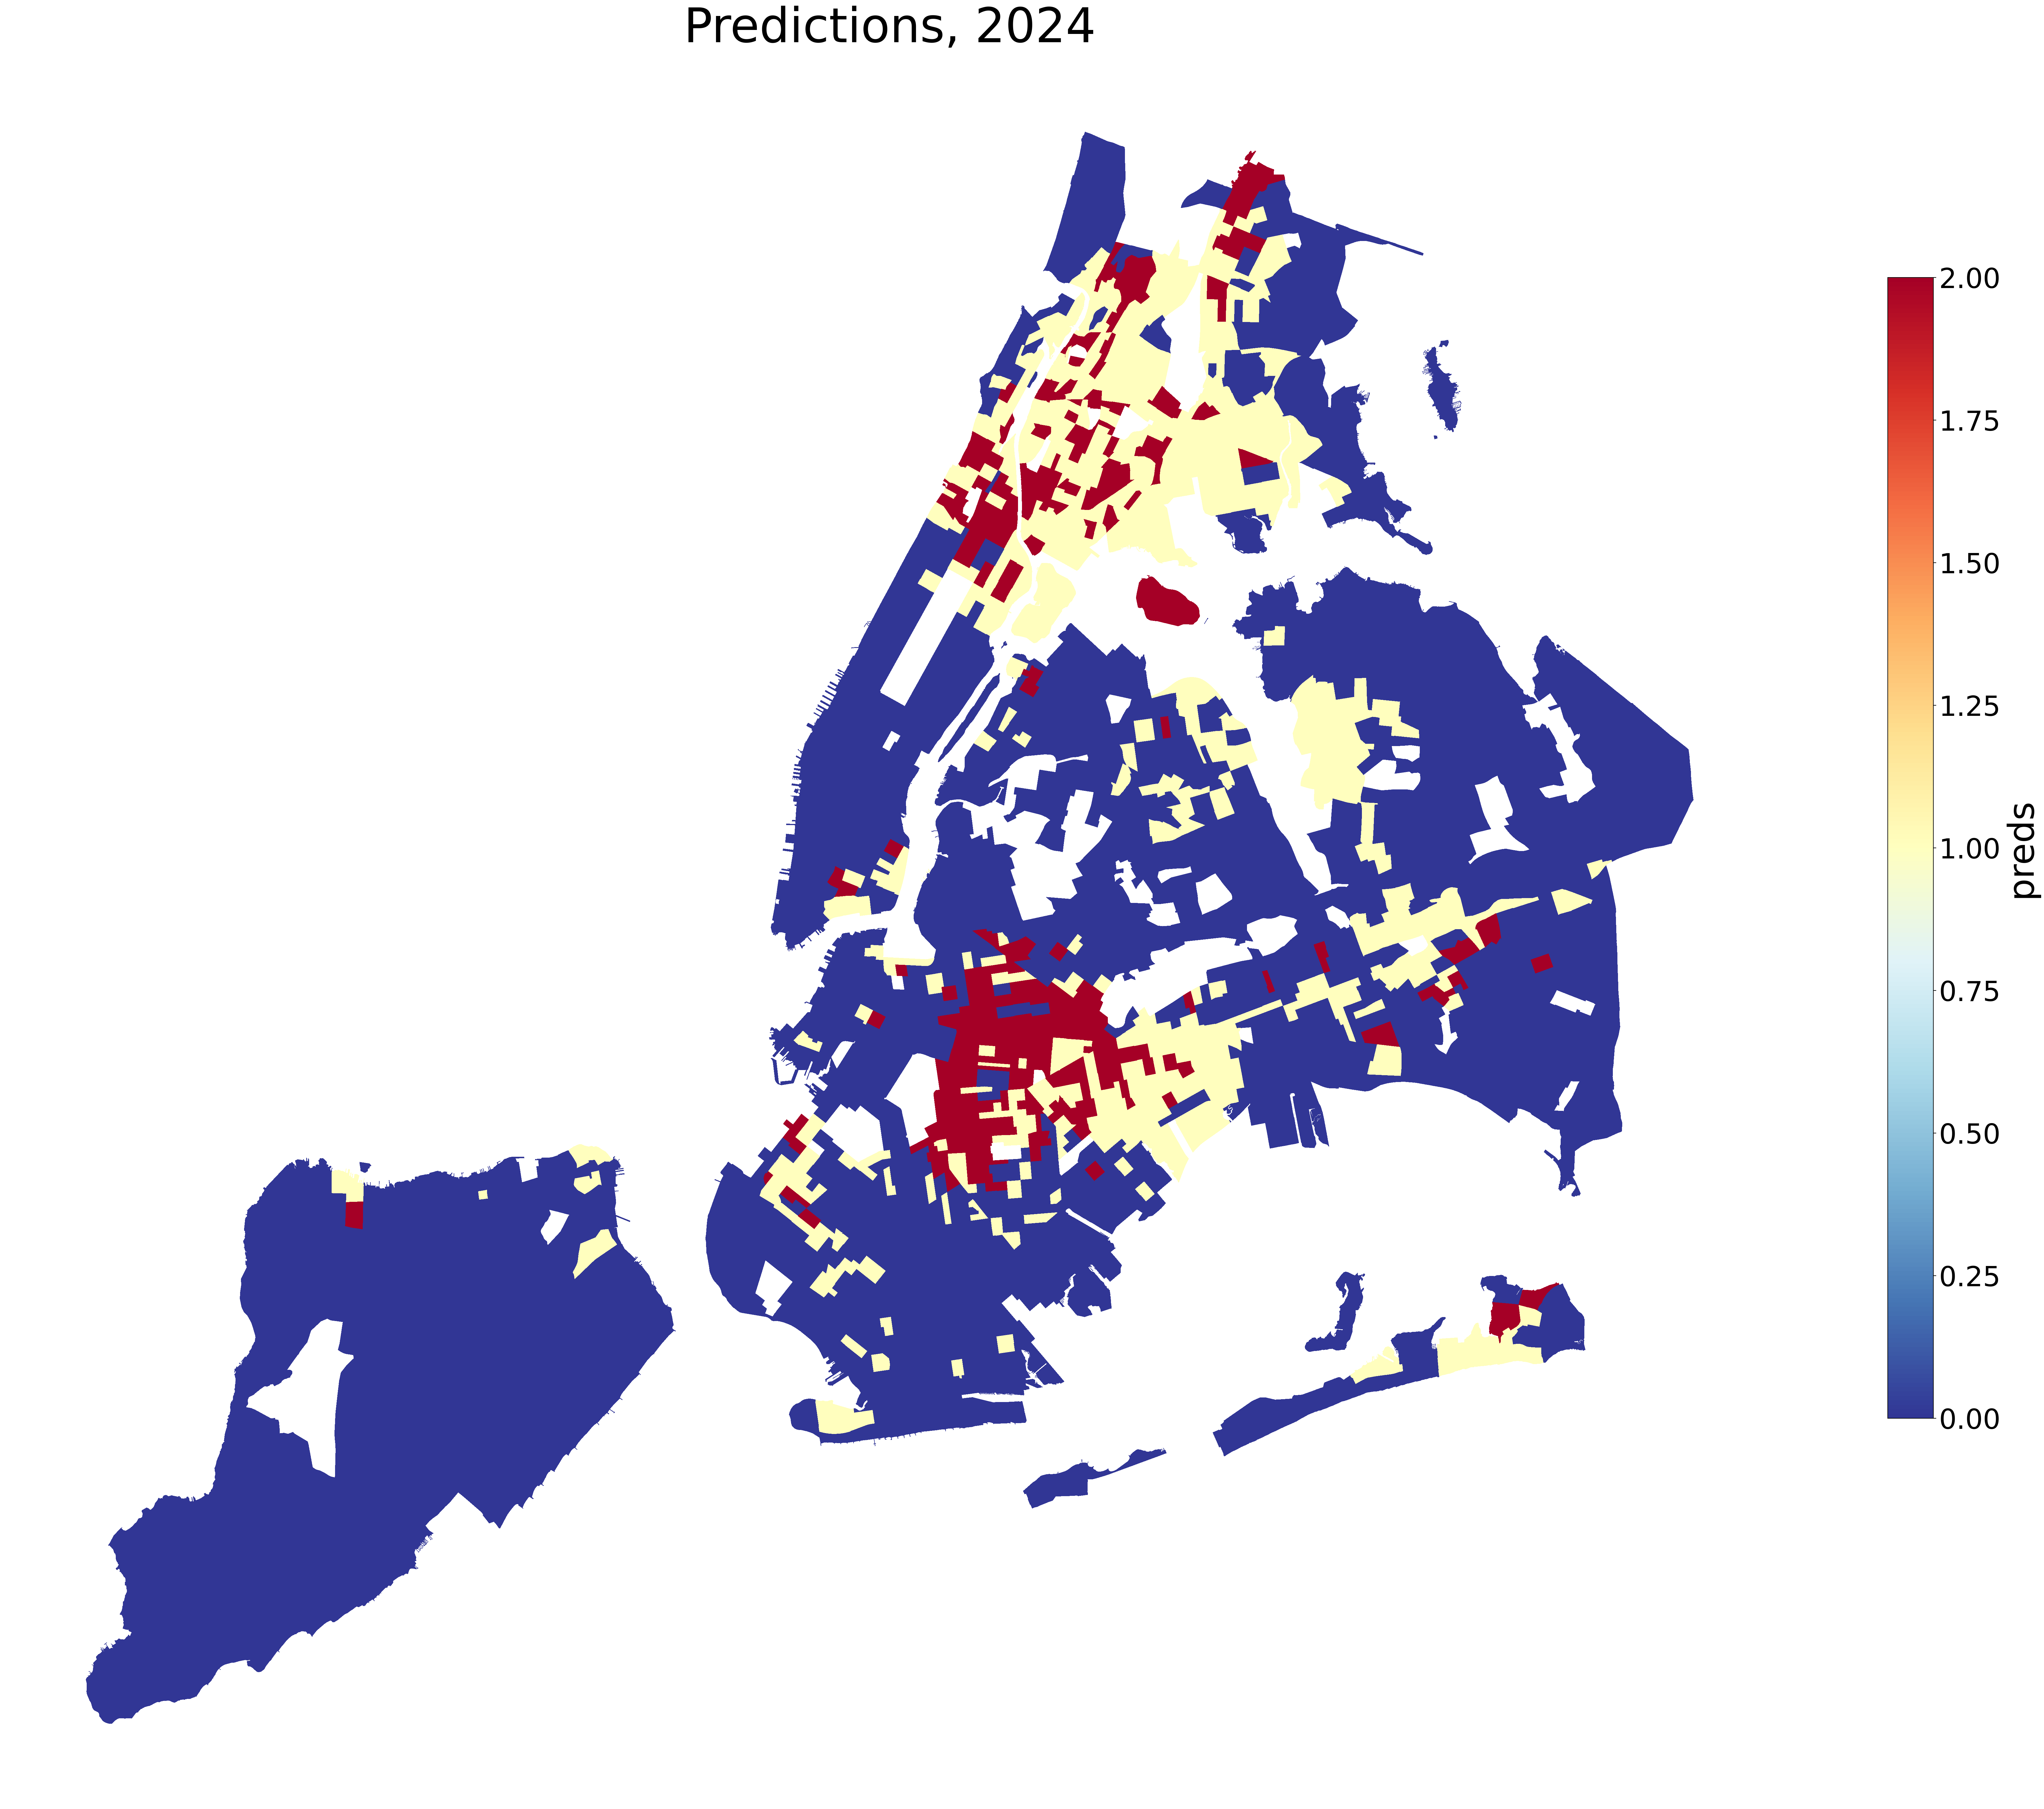

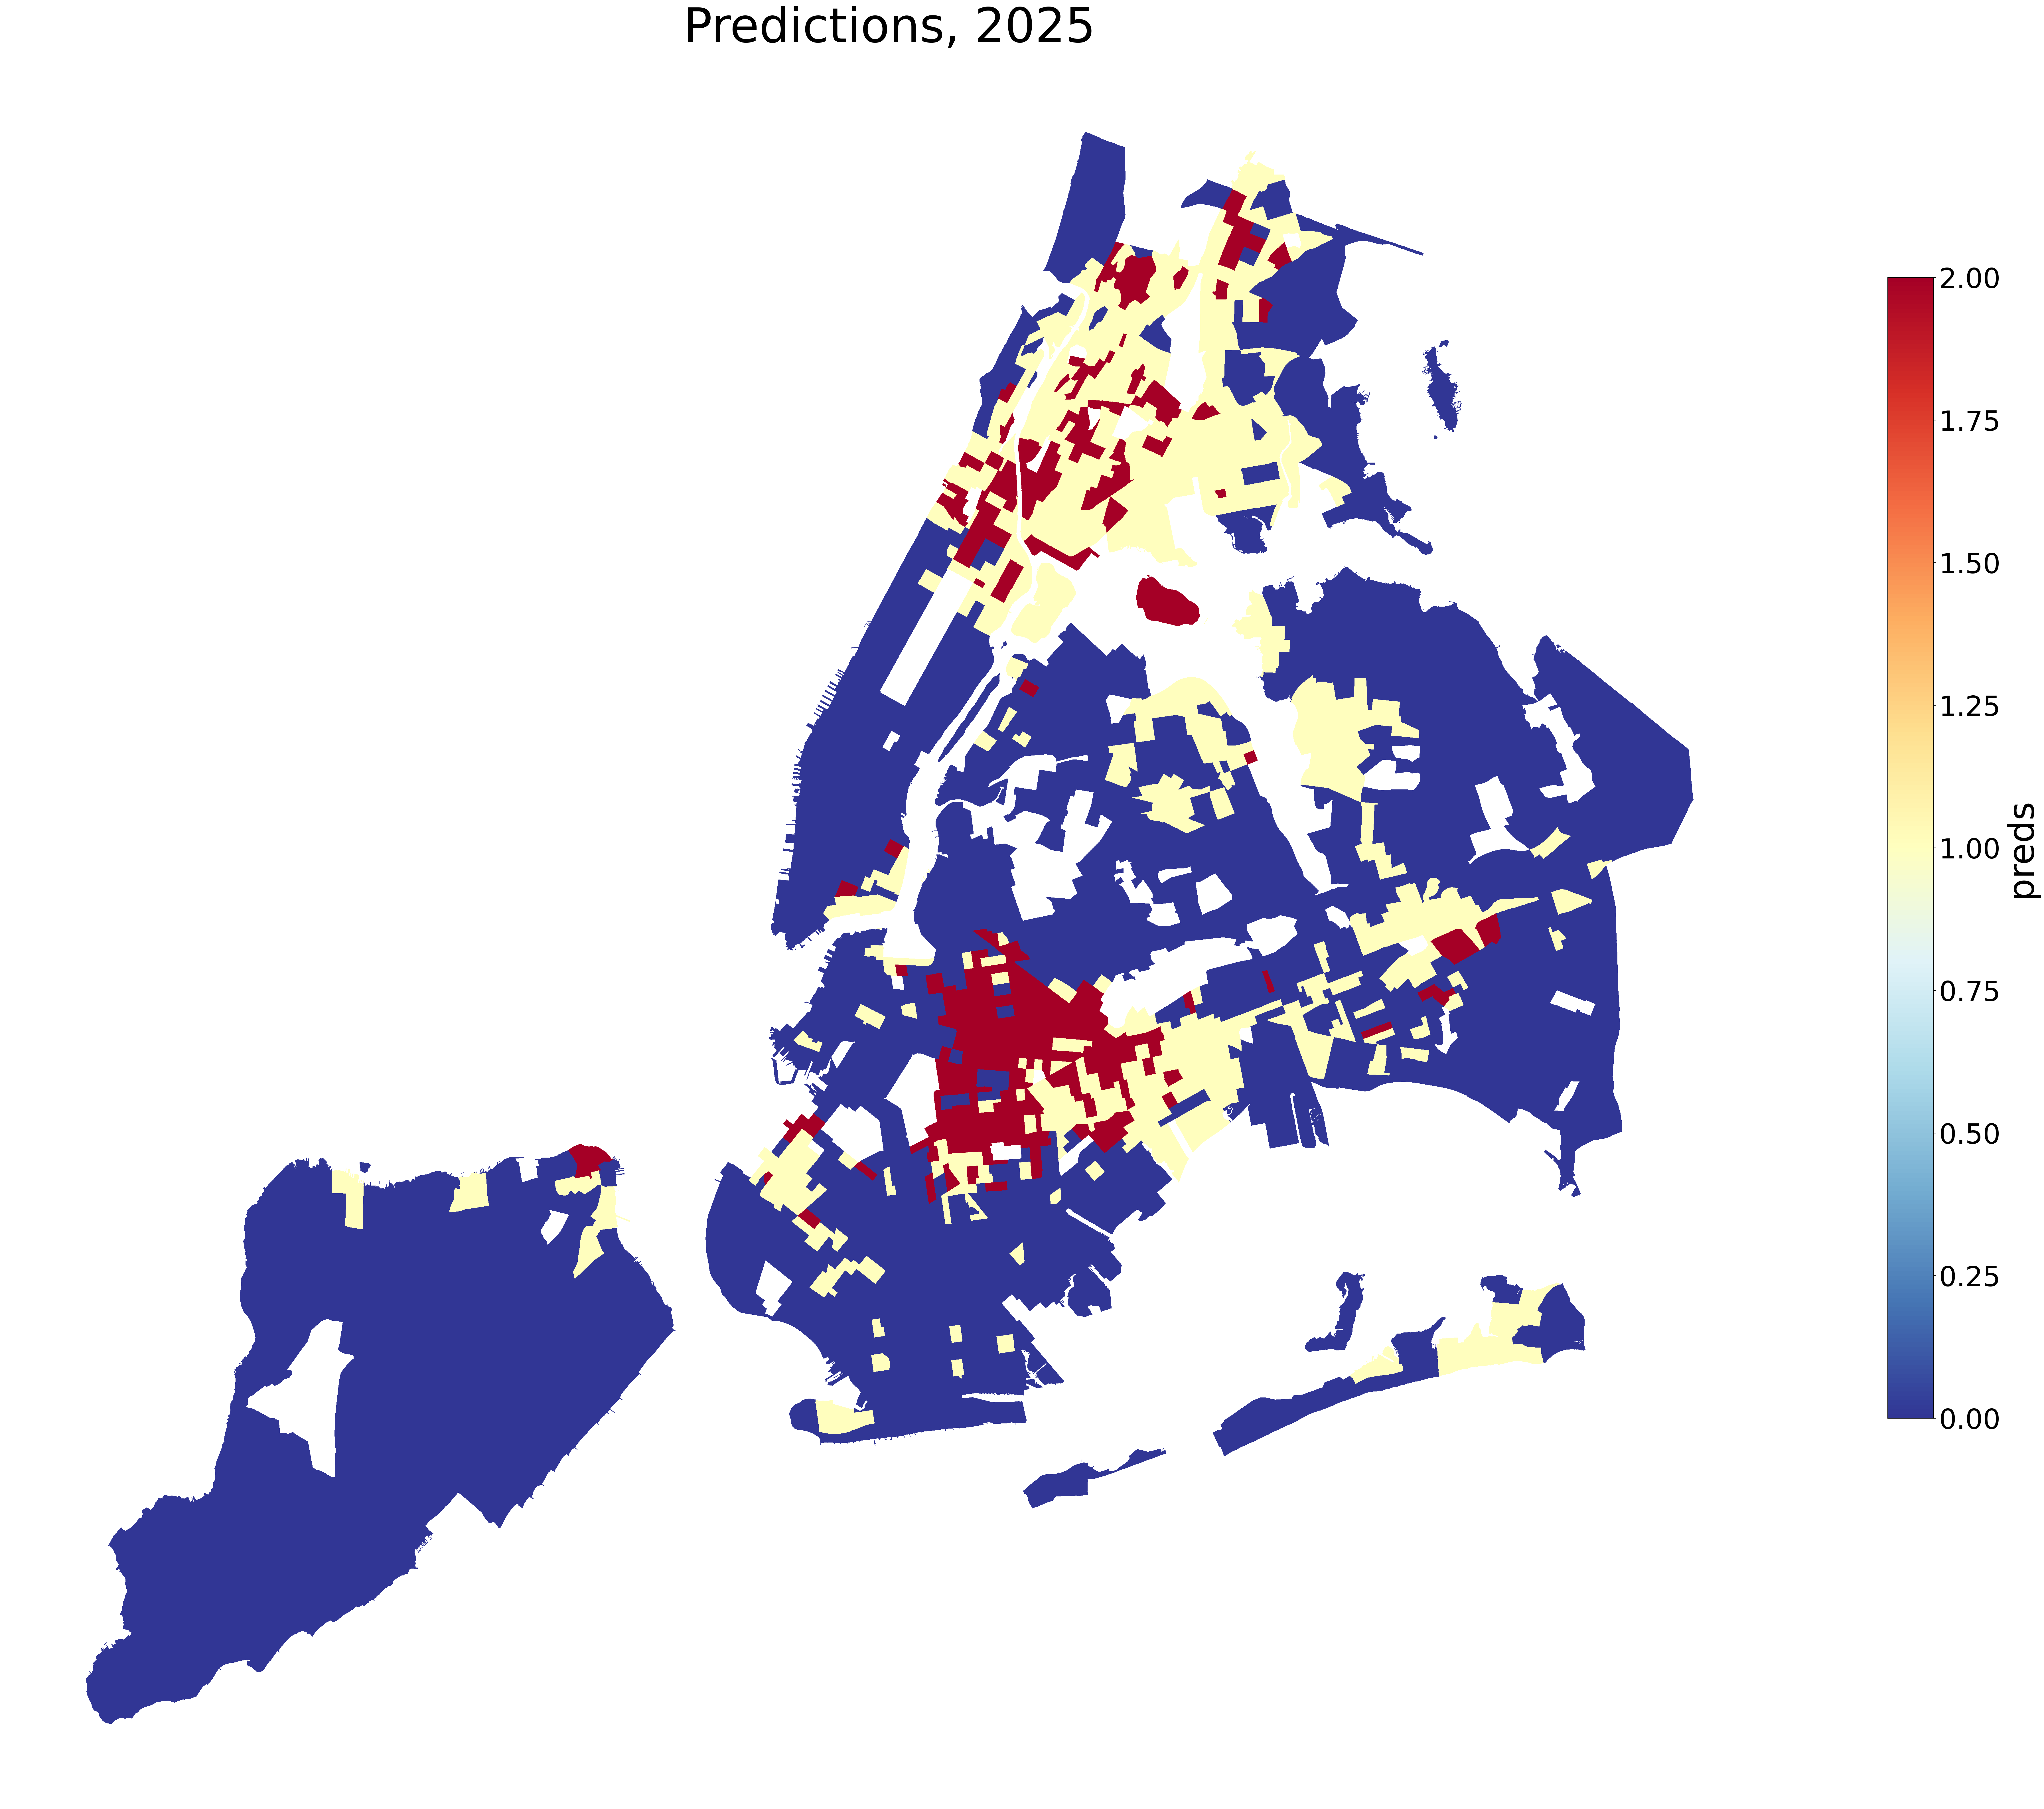

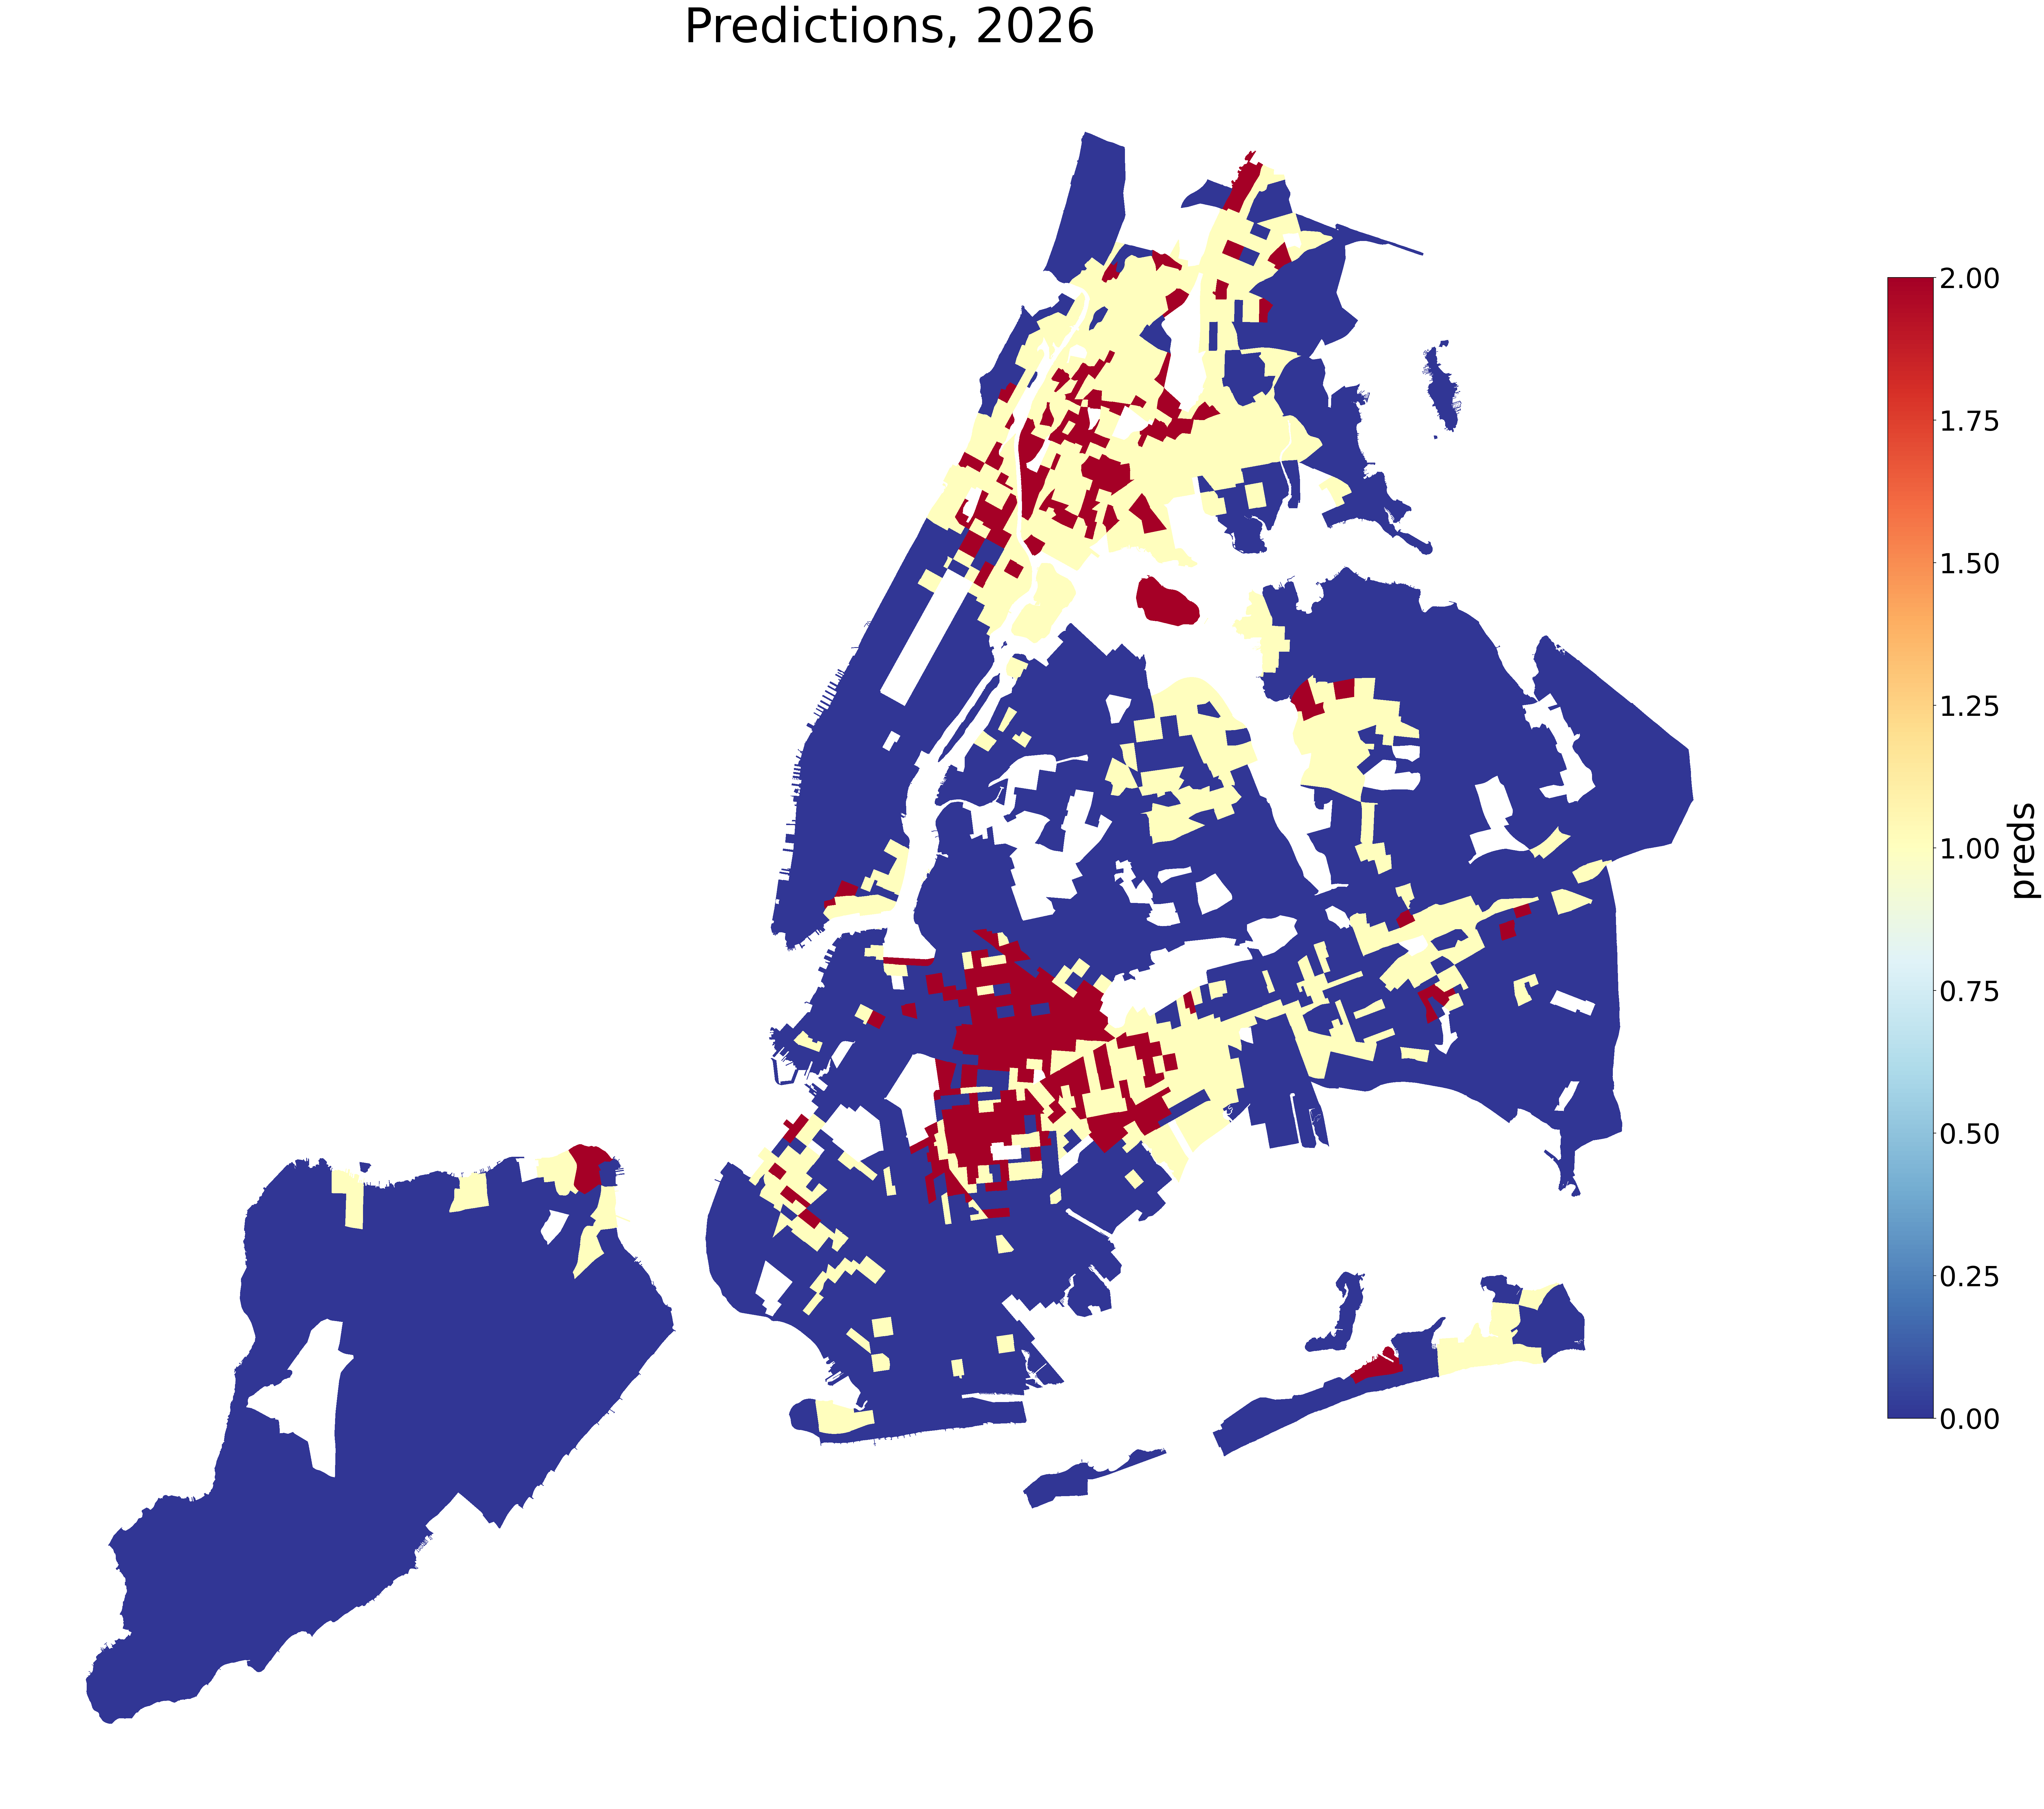

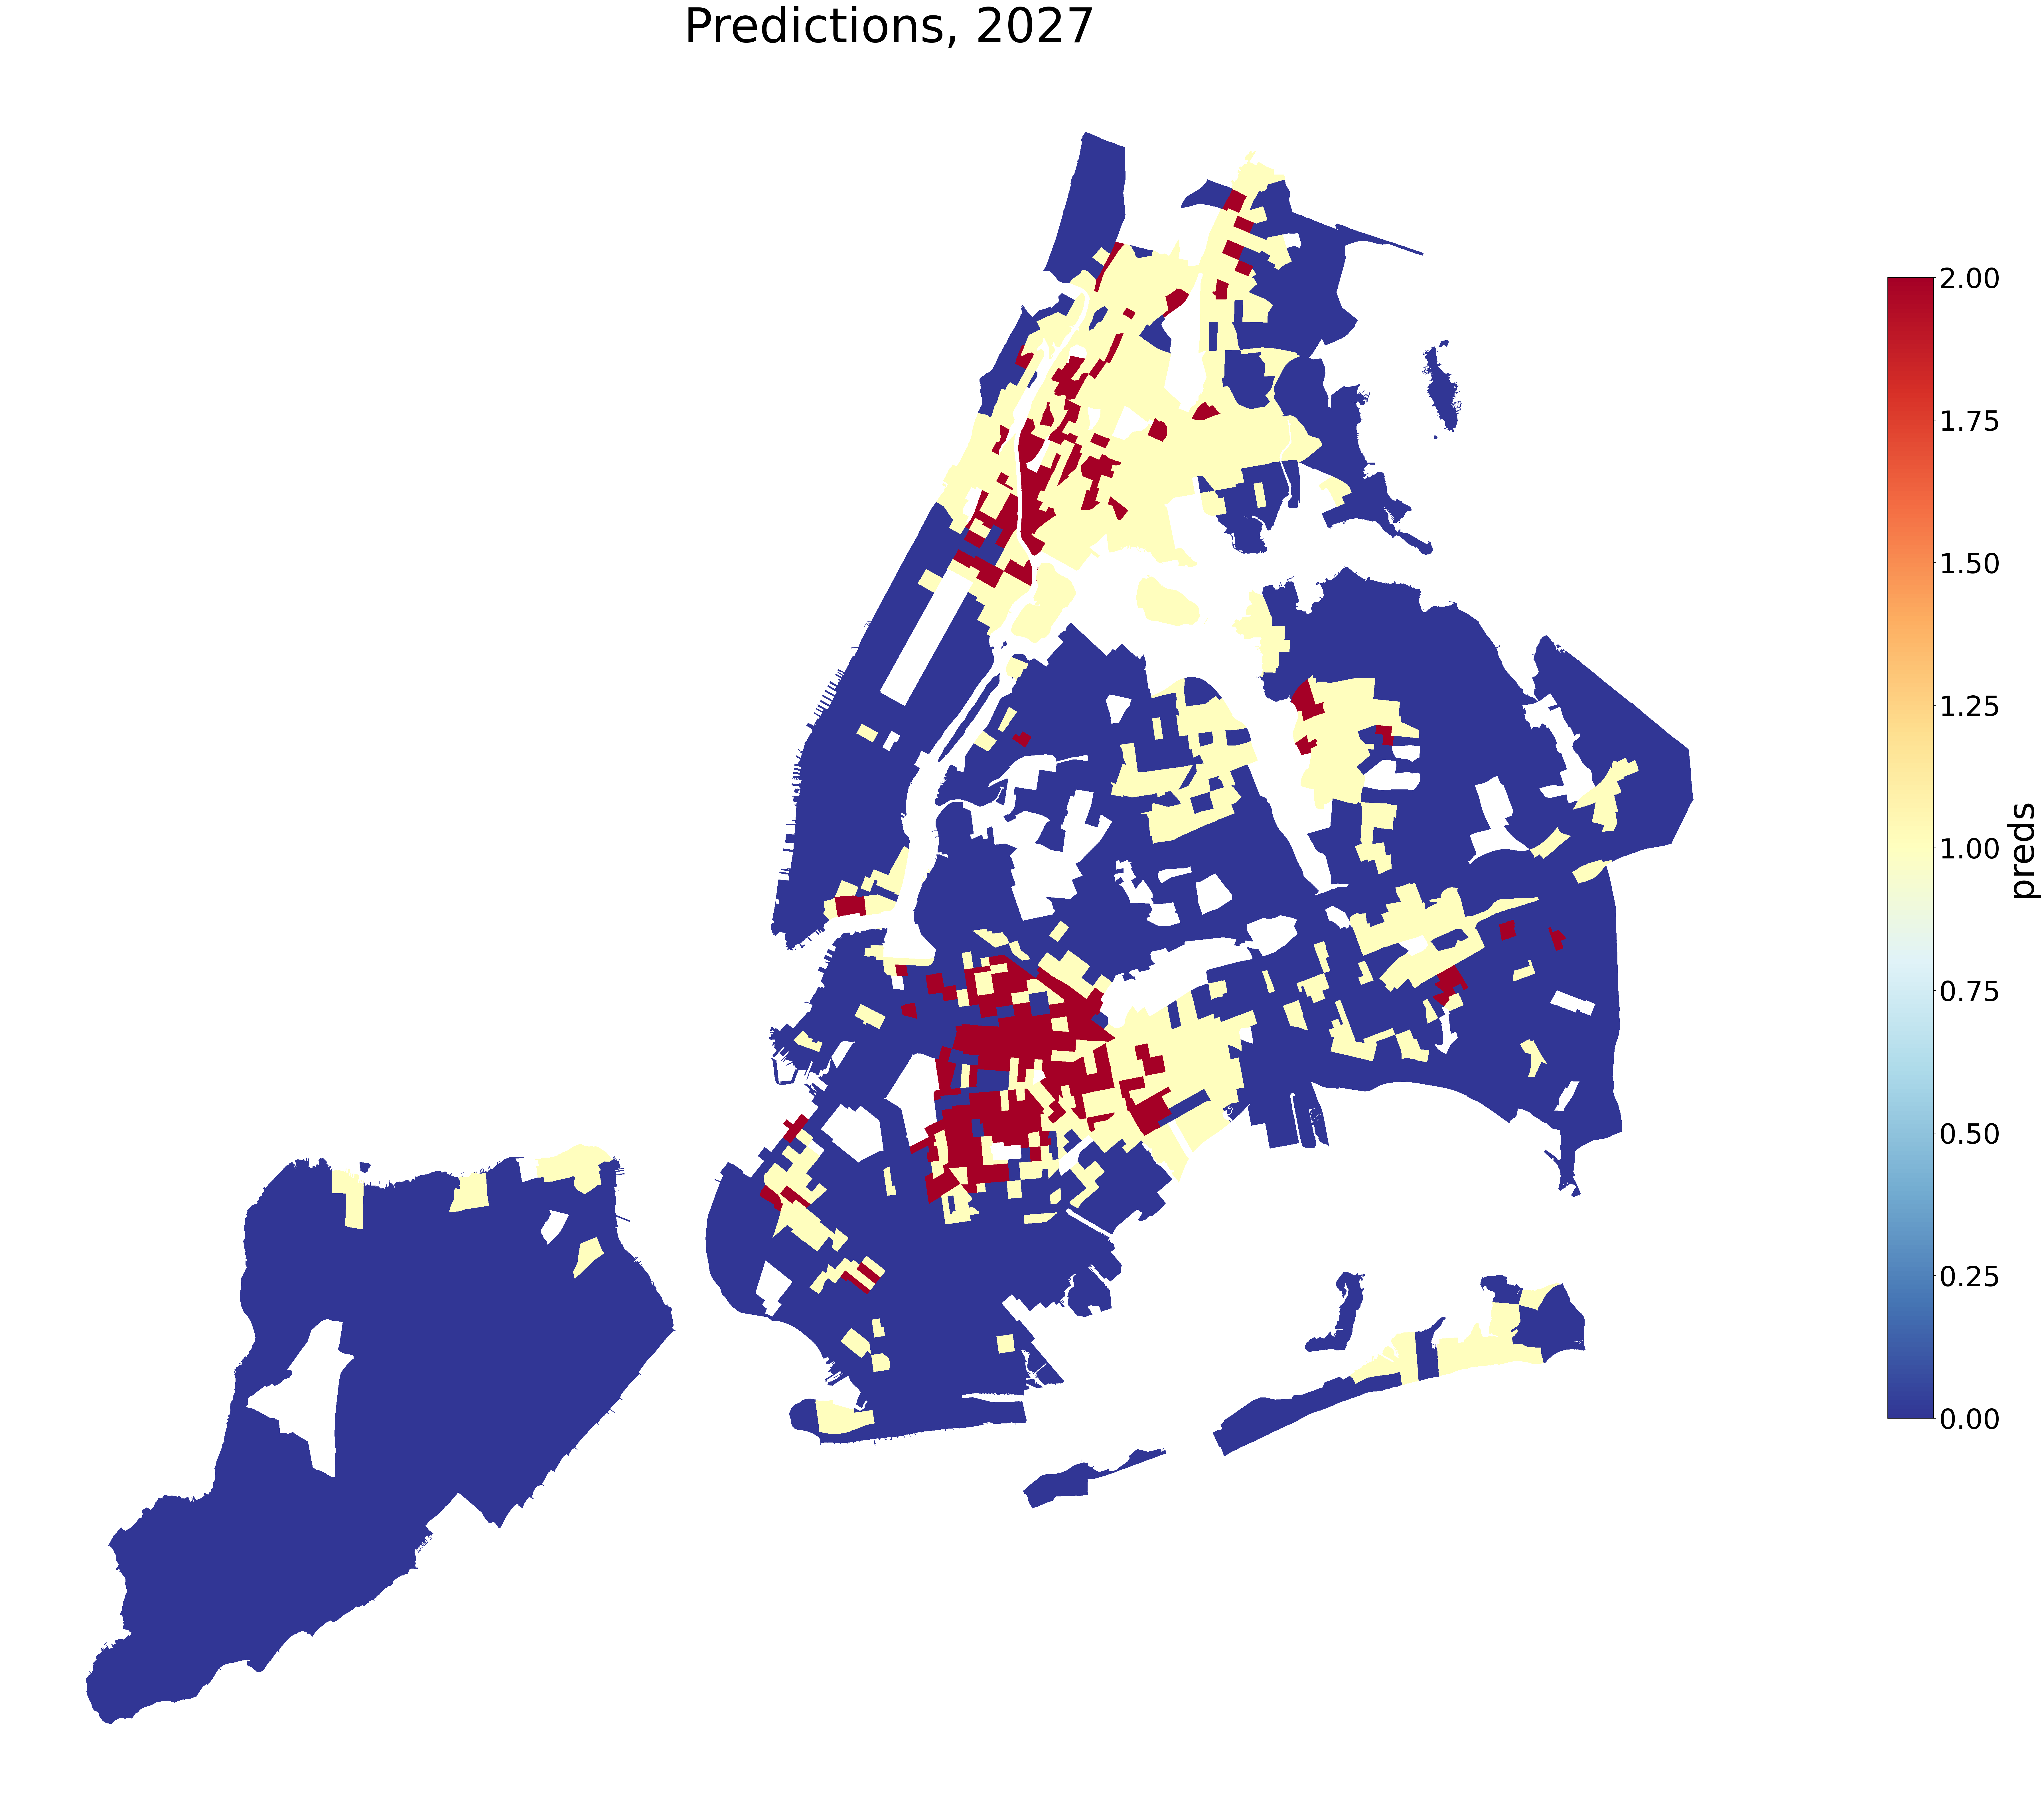

In [7]:
# visualize preds
choropleth(pred_set,'preds',['2024','2025','2026','2027'], cmap='RdYlBu_r', title='Predictions', save_img=True)

In [268]:
# pred_set.to_parquet('Data/Cleaned/future_preds.parquet')

## Individual Year Predictions
No cross validation used

In [37]:
# Split train/test/pred Set
train_set_full = df[df.pred_year.isin(['2022','2020','2021'])]
test_set_full = df[df.pred_year.isin(['2023'])]

# add our case study Census Tracts to teh test set to inspect Shap values later
set_to_move = train_set_full[train_set_full.GEOID.isin(['36061015602','36047044300'])]
train_set_full.drop(set_to_move.index, inplace=True)
test_set_full = pd.concat([test_set_full, set_to_move])

# limit train/test sets to vulnerable/gentrified tracts only
train_set = train_set_full[train_set_full.label!=0]
test_set = test_set_full[test_set_full.label!=0]

# define feature set and split data
feat = ['total_pop', 'percent_hh_income_assist', 'percent_hh_snap',
       'percent_hh_english', 'percent_work_agriculture',
       'percent_work_construction', 'percent_work_retail',
       'percent_work_finance', 'percent_work_stem', 'percent_work_edu_health',
       'percent_work_art', 'percent_out_of_county',
       'percent_moved_within_county', 'percent_public_transit',
       'percent_drive_commute', 'percent_bike_commute', 'percent_walk_commute',
       'percent_wfh', 'percent_white', 'percent_black', 'percent_native',
       'percent_asian', 'percent_pacific', 'percent_latino',
       'percent_bachelors', 'percent_grad', 'percent_born_citizen',
       'percent_naturalized_citizen', 'percent_not_citizen',
       'percent_same_house_1yr', 'percent_out_of_state', 
       'med_rent_acs', 'med_age', 'med_value','med_income','med_rent',
       'percent_hh_electric', 'percent_hh_solar', 'med_hh_age',
       'med_hh_tenure', 'num_citibike_rides', 'num_trees', 
       'num_affordable_hous_built', 'num_bikelanes','percent_hh_rented',
       'num_evictions_commercial', 'num_evictions_residential', 'park_acres',
       'num_parks', 'lag_vulnerable','lag_ever_gentrified']

# labels
y_train = train_set['label']
y_test = test_set['label']

# features
X_train = train_set[feat]
X_test = test_set[feat]

# Apply SMOTE to the training data to upsample minority class
smote = SMOTE(sampling_strategy='auto')
X_train, y_train = smote.fit_resample(X_train, y_train)


In [38]:
###### Fit the Model
forest_yr = RandomForestClassifier(n_estimators=100, random_state=65)
forest_yr.fit(X_train, y_train)

# predict
y_train_pred = forest_yr.predict(X_train)
y_test_pred = forest_yr.predict(X_test)
y_probs = forest_yr.predict_proba(X_test)[:, 1]  # Probability estimates for the positive class

# put preds into a df
test_set['preds'] = y_test_pred
test_set_full = pd.concat([test_set, test_set_full[test_set_full.label==0]])
test_set_full['year'] = '2023'
test_set_full['preds'].fillna(0, inplace=True)

# performance scores
train_score = precision_score(y_train, y_train_pred)
test_score =  precision_score(y_test, y_test_pred)
print("Train Score:", train_score)
print("Test Score:", test_score)

# Compute ROC curve and AUC
y_test = np.where(y_test==2,1,0)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
print("AUC of ROC Curve:", roc_auc)

# visualize preds
# choropleth(test_set_full,'preds',['2020'], cmap='RdYlBu_r',title='Predictions', save_img=True)
# choropleth(test_set_full,'label',['2023'], cmap='RdYlBu_r',title='Ground Truth', save_img=False)


Train Score: 1.0
Test Score: 0.86652977412731
AUC of ROC Curve: 0.8997843869476305


In [83]:
# test_set.to_parquet('Data/Cleaned/2020_preds.parquet')

### ROC Curve

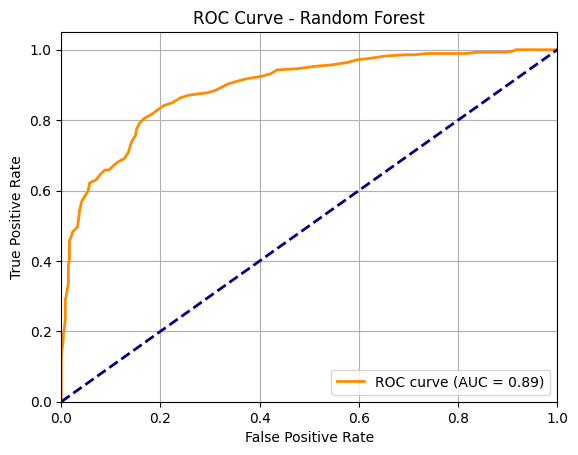

In [84]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Shap Values

100%|===================| 1524/1530 [00:48<00:00]        

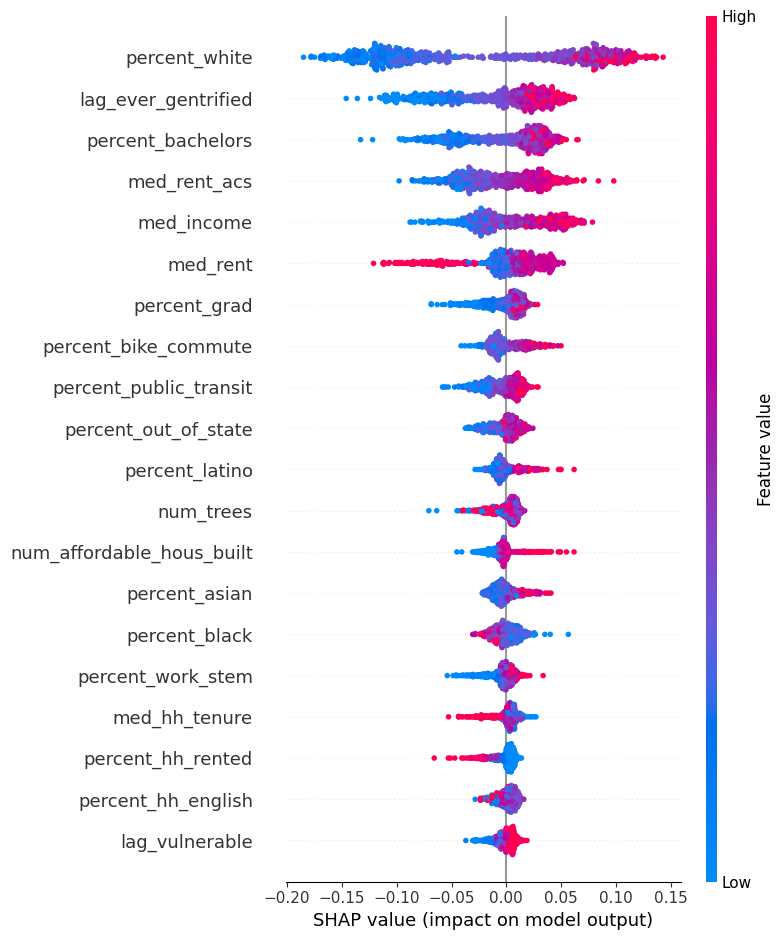

In [39]:
explainer = shap.Explainer(forest_yr, X_train) 
shap_values = explainer(X_test)

# Choose the class to explain (1=gentrifying)
class_idx = 1
shap_class1_values = shap_values[:, :, class_idx]

# Plot summary
shap.summary_plot(shap_class1_values, X_test, plot_type='dot', show=False);
# plt.savefig('Images/SHAP.png', transparent=True)


## Look at individual observations

In [40]:
test_set.reset_index(drop=True, inplace=True)
cases = test_set[test_set.GEOID.isin(['36061015602','36047044300'])]


In [41]:
cases = cases[['pred_year','GEOID','label', 'preds', 'total_pop', 'percent_hh_income_assist', 'percent_hh_snap',
       'percent_hh_english', 'percent_work_agriculture',
       'percent_work_construction', 'percent_work_retail',
       'percent_work_finance', 'percent_work_stem', 'percent_work_edu_health',
       'percent_work_art', 'percent_out_of_county',
       'percent_moved_within_county', 'percent_public_transit',
       'percent_drive_commute', 'percent_bike_commute', 'percent_walk_commute',
       'percent_wfh', 'percent_white', 'percent_black', 'percent_native',
       'percent_asian', 'percent_pacific', 'percent_latino',
       'percent_bachelors', 'percent_grad', 'percent_born_citizen',
       'percent_naturalized_citizen', 'percent_not_citizen',
       'percent_same_house_1yr', 'percent_out_of_state', 'med_income',
       'med_rent_acs', 'med_age', 'percent_hh_rented', 'med_value',
       'percent_hh_electric', 'percent_hh_solar', 'med_hh_age',
       'med_hh_tenure', 'num_citibike_rides', 'num_trees', 'med_rent',
       'num_affordable_hous_built', 'num_bikelanes',
       'num_evictions_commercial', 'num_evictions_residential', 'park_acres',
       'num_parks',  'lag_vulnerable', 'lag_ever_gentrified',
       'ever_gentrified']]
cases

,pred_year,GEOID,label,preds,total_pop,percent_hh_income_assist,percent_hh_snap,percent_hh_english,percent_work_agriculture,percent_work_construction,percent_work_retail,percent_work_finance,percent_work_stem,percent_work_edu_health,percent_work_art,percent_out_of_county,percent_moved_within_county,percent_public_transit,percent_drive_commute,percent_bike_commute,percent_walk_commute,percent_wfh,percent_white,percent_black,percent_native,percent_asian,percent_pacific,percent_latino,percent_bachelors,percent_grad,percent_born_citizen,percent_naturalized_citizen,percent_not_citizen,percent_same_house_1yr,percent_out_of_state,med_income,med_rent_acs,med_age,percent_hh_rented,med_value,percent_hh_electric,percent_hh_solar,med_hh_age,med_hh_tenure,num_citibike_rides,num_trees,med_rent,num_affordable_hous_built,num_bikelanes,num_evictions_commercial,num_evictions_residential,park_acres,num_parks,lag_vulnerable,lag_ever_gentrified,ever_gentrified
403,2023,36047044300,2,1,-0.054923,0.266445,-0.026293,0.061743,0.302274,-0.128233,0.005387,0.165410,0.076818,0.071273,0.082545,0.038917,-0.107471,0.031329,-0.032597,0.226121,0.035848,0.643052,-0.000284,0.045891,0.0,0.124896,0.000000,-0.042807,0.205860,0.128021,0.052711,0.046060,-0.090223,0.017815,-0.109359,-0.007608,0.028125,0.030777,11.566999,0.063368,0.112993,0.0,-0.200000,-0.053977,0.000000,0.019220,0.027108,0.0,0.0,-0.048095,1.291545,0.0,0.0,0.500000,0.666667,1
550,2023,36061015602,1,1,0.012915,-0.190194,-0.053725,0.103961,0.000000,-0.041608,-0.061519,-0.041284,0.075148,0.139927,-0.122421,-0.045833,0.030817,-0.005979,0.095096,0.000000,0.200286,-0.001817,0.027602,0.056154,0.0,-0.088039,0.244335,0.003450,-0.006257,0.033182,0.029472,-0.080874,-0.000462,0.001408,-0.024526,0.086843,-0.016008,-0.006315,0.002593,-0.010321,0.038241,0.0,-0.023325,-0.072075,0.531495,0.016053,0.026763,0.0,0.0,-1.000000,-0.128567,0.0,0.0,0.285714,0.142857,1
759,2020,36047044300,2,2,-0.020587,0.355571,0.014686,0.114525,0.250032,-0.020328,0.041797,-0.008432,0.072079,0.050890,-0.043161,0.012165,-0.062683,0.083791,-0.051579,0.251743,-0.022517,0.508542,0.131724,0.358405,0.0,0.080014,0.000000,-0.011340,0.151409,0.125336,0.015062,0.014131,-0.025844,0.003655,0.131599,0.048730,0.044119,0.022526,13.906989,0.008766,0.139748,0.0,0.000000,-0.039864,0.000000,0.019755,0.039225,0.0,0.0,0.408333,0.176550,0.0,0.0,0.666667,2.000000,-1
760,2020,36061015602,2,2,0.031570,0.206592,0.097413,0.043039,0.000000,-0.109854,0.321435,-0.086734,0.116048,0.048989,0.045557,-0.219985,-0.149259,-0.001095,0.134385,0.000000,0.199120,0.109825,0.055797,0.042812,0.0,0.007097,0.000000,0.002156,0.087948,0.005196,0.021906,-0.014519,0.067979,0.042959,-0.143446,0.056976,0.072703,0.032639,-0.346185,-0.000398,0.021274,0.0,-0.024619,-0.015512,0.000000,0.014132,0.024536,0.0,0.0,0.000000,-0.104933,0.0,0.0,0.428571,2.000000,-1
761,2021,36047044300,2,2,-0.037152,0.284108,0.012308,0.155891,0.211746,-0.055738,0.085102,0.092393,0.098037,0.078421,-0.011764,-0.016877,-0.074860,0.058962,-0.019059,0.245087,-0.005210,0.598390,0.131809,0.357485,0.0,0.139761,0.000000,-0.044218,0.180627,0.136989,0.040153,0.081439,-0.083632,0.009338,0.003862,0.024726,0.030498,0.024603,11.587016,-0.007772,0.271597,0.0,0.000000,-0.032618,0.000000,0.019966,0.034036,-1.0,0.0,0.265476,0.148337,0.0,0.0,0.666667,0.666667,1
762,2021,36061015602,1,1,0.023629,-0.165377,0.017570,0.073709,0.000000,0.146162,-0.005069,-0.060172,0.146033,0.032219,0.068304,-0.156871,-0.115413,-0.004850,0.185204,0.000000,0.245208,-0.020516,0.031890,0.071257,0.0,-0.086853,0.212168,0.011403,-0.015627,0.004989,0.044048,-0.111535,0.042993,0.037956,-0.165127,0.039728,0.001301,0.021065,-0.349048,0.012563,0.058267,0.0,-0.022591,-0.024772,1.003449,0.013897,0.027619,0.0,0.0,0.000000,-0.117735,0.0,0.0,0.428571,0.142857,1
763,2022,36047044300,2,2,-0.035306,0.210245,-0.004906,0.117808,0.212888,-0.063442,0.136760,-0.001565,0.104845,0.023642,0.084317,0.037015,-0.083776,0.048428,-0.077890,0.320835,0.026730,0.566168,0.036178,0.134037,0.0,0.10337

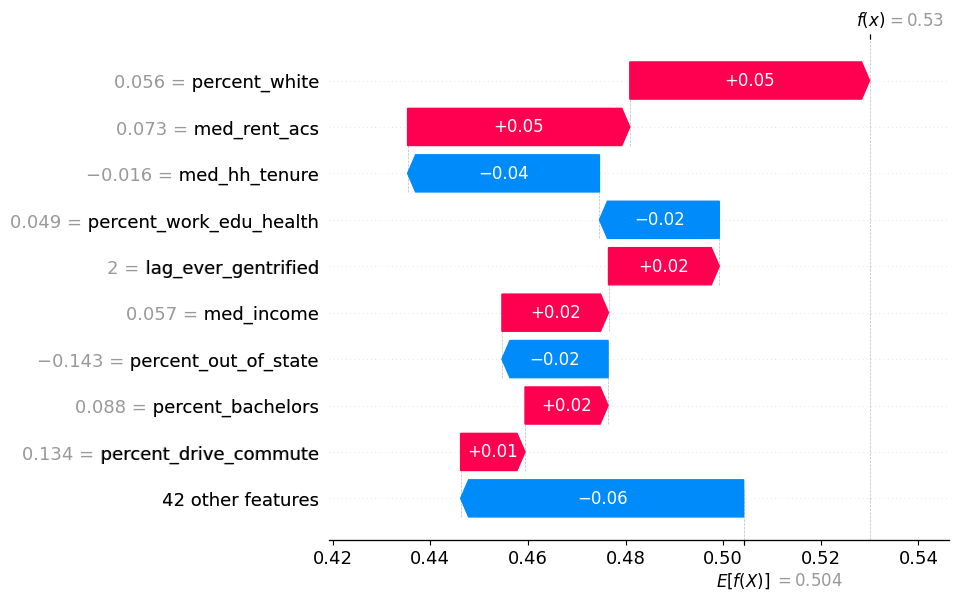

In [44]:
# Harlem - 36061015602
shap.plots.waterfall(shap_class1_values[760])

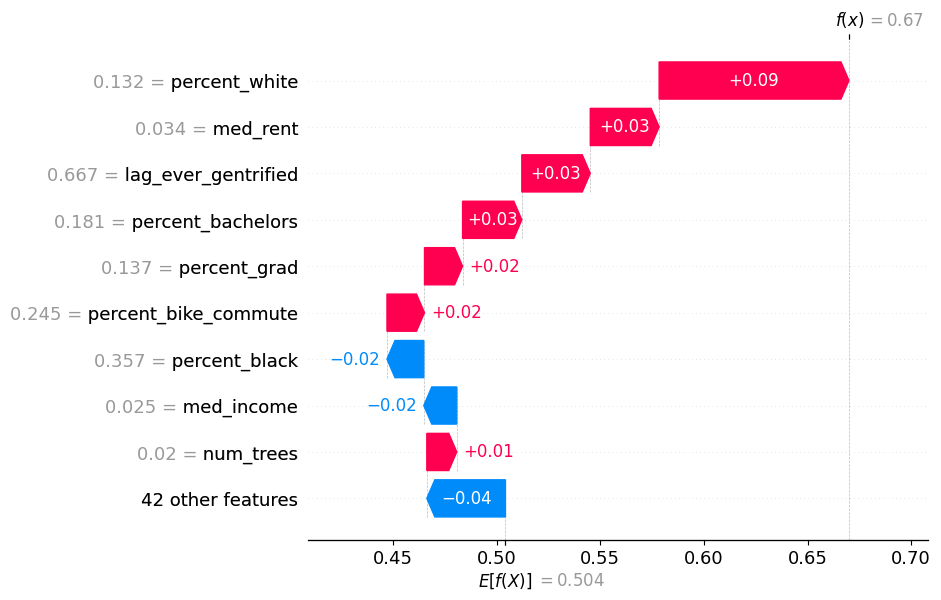

In [47]:
# Bushwick - 36047044300 (2021)
shap.plots.waterfall(shap_class1_values[761])

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (2).

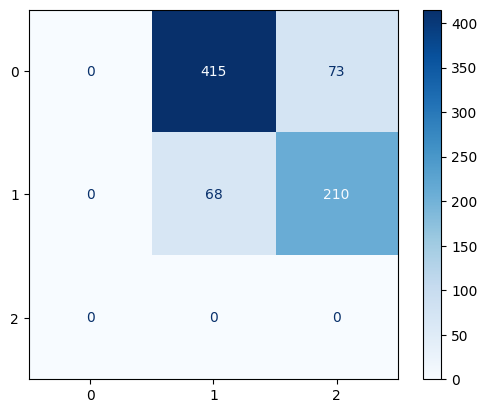

In [100]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_set['label'].unique())
disp.plot(cmap=plt.cm.Blues)

# Show the plot
plt.title("Confusion Matrix")
plt.show()